## Import required packages 

In [1]:
import pandas as pd
import numpy as np
import requests
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

import logging
import sys

from prophet import Prophet

%matplotlib inline

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Extract stock prices for each 

In [2]:
def get_stock_prices(api_key, tckr): 
    '''
    Input 
    api_key - unique key from polgon.io that you get for signing up
    tckr - the stock that values need to be extracted 

    Ouput 
    df - volume, price, open, close, high and low stock prices for the stock for each day for the previous 2 years 
         (2 years is the maxiumum time span for the free trial of polygon.io )
    '''
    url = f'https://api.polygon.io/v2/aggs/ticker/{tckr}/range/1/day/2023-01-19/2025-01-19?apiKey={api_key}'
    
    response = requests.get(url)
    data = response.json()
    
    # Convert the JSON data to a pandas DataFrame
    df = pd.DataFrame(data['results'])
    
    # Convert the timestamp to a readable date format
    df['t'] = pd.to_datetime(df['t'], unit='ms')
    
    # Display the historical data
    return df

In [3]:
# Input your API key for polygon.io
api_key = 'BIf89HTb0NaGQsWozgDr5x1W8GfFC3MH'
# Choose 4 stores that are closest competitors as we can only download 5 a min with the free API 
stocks = ['GLW','APH','DLB','LFUS','ROG']

stock_prices_df = pd.DataFrame([])

for tckr in stocks:
    stock_prices_df_pre = get_stock_prices(api_key, tckr)
    stock_prices_df_pre.columns = [f"{col}_{tckr}" if col != 't' else col for col in stock_prices_df_pre.columns]
    if stock_prices_df.empty:
        stock_prices_df = stock_prices_df_pre
    else:
        stock_prices_df = stock_prices_df.merge(stock_prices_df_pre, on='t', how='outer')

# Stock we wish to predict future sales for 
pred_stock = 'o_GLW'

In [4]:
stock_prices_df.head()

,v_GLW,vw_GLW,o_GLW,c_GLW,h_GLW,l_GLW,t,n_GLW,v_APH,vw_APH,...,h_LFUS,l_LFUS,n_LFUS,v_ROG,vw_ROG,o_ROG,c_ROG,h_ROG,l_ROG,n_ROG
0,14063381.0,34.7587,36.39,34.61,36.390,34.42,2023-01-31 05:00:00,85245,3985268.0,39.6540,...,257.44,246.750,4304,292621.0,139.0927,137.02,139.59,140.82,136.000,6958
1,6855265.0,35.1585,34.52,35.28,35.590,34.22,2023-02-01 05:00:00,64659,4589076.0,40.2755,...,264.37,256.290,4942,250997.0,138.7420,139.22,139.16,140.94,136.750,6351
2,4848807.0,35.9855,35.49,36.29,36.335,34.98,2023-02-02 05:00:00,43933,5367528.0,40.9325,...,278.18,243.860,7619,1125417.0,130.1767,140.22,143.76,144.09,139.225,10421
3,3572644.0,35.9463,35.90,35.74,36.440,35.64,2023-02-03 05:00:00,35034,5825416.0,40.8352,...,272.79,258.479,5846,415919.0,145.2770,141.72,146.99,147.12,140.810,8453
4,4514611.0,35.1156,35.27,35.02,35.410,35.01,2023-02-06 05:00:00,35884,4533618.0,40.8324,...,267.88,260.525,4487,742779.0,152.2657,150.57,149.26,156.56,148.615,15648


## See if any data is missing 

In [5]:
stock_prices_df.isna().sum().sum()

np.int64(0)

In [6]:
stock_prices_df.isin([np.inf, -np.inf]).sum().sum()

np.int64(0)

In [7]:
# No missing data, all has been pulled through from the API 

## Exploritory analysis

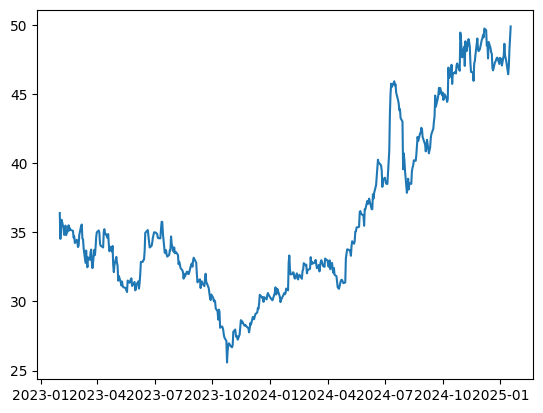

In [8]:
# look at trend over time 
plt.plot(stock_prices_df['t'],stock_prices_df[pred_stock])

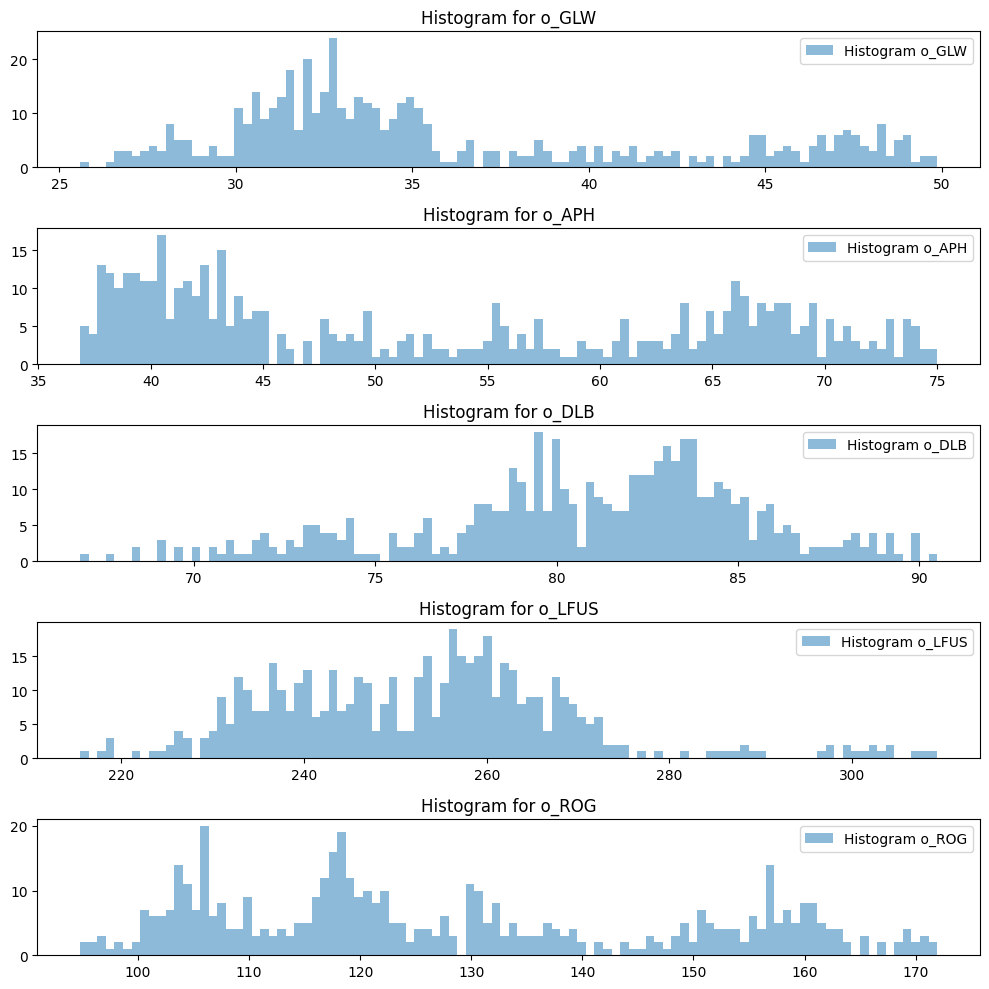

In [9]:
# Most stocks are not normally distributed so make sure methods do not assume this 
fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for i, tckr in enumerate(stocks):
    tckr = 'o_' + tckr 
    axs[i].hist(stock_prices_df[tckr], bins=100, alpha=0.5, label=f'Histogram {tckr}')
    axs[i].set_title(f'Histogram for {tckr}')
    axs[i].legend()

plt.tight_layout()
plt.show()

## Auto regression 
Understand if previous values in previous time series contribute to fucture 

In [54]:
def autocorrelation_check(df, target_col, col, min_lag=5, max_lag=50):
    ''' 
    Input 
    df - stock prices data of stocks and competitors
    target_col - the prediction stock
    col - column to check for autocorrelation
    min_lag - minimum number of lags
    max_lag - maximum number of lags 

    Output 
    correlation_df - Correlation up to the maximum lag between the prediction column and the input column 
    '''

    correlations = [
        {'lag': lag, 'correlation': df[target_col].corr(df[col].shift(lag))} for lag in range(min_lag, max_lag + 1)
    ]
    
    return pd.DataFrame(correlations)

def generate_top_correlations(df, target_col=pred_stock, min_lag=5, max_lag=50):
    ''' 
    Input 
    df - stock prices data of stocks and competitors
    target_col - the prediction stock
    col - column to check for autocorrelation
    min_lag - minimum number of lags
    max_lag - maximum number of lags 

    Output 
    top_correlations - All lagged correlations from the original data frame with the target column 
    '''
    i = 0

    all_correlations = []
    for col in df.columns:
        if col == 't':
            continue
        correlation_df = autocorrelation_check(df, target_col, col, min_lag, max_lag)
        correlation_df['column'] = col
        all_correlations.append(correlation_df[correlation_df['correlation'].abs() == correlation_df['correlation'].abs().max()])
        #print(correlation_df[correlation_df['correlation'] == correlation_df['correlation'].max()])
        i += 1
    print(i)
    
    all_correlations_df = pd.concat(all_correlations)
    
    # Select only the relevant columns
    top_correlations = all_correlations_df[['column', 'lag', 'correlation']]
    
    return top_correlations

In [57]:
top_corr_columns = generate_top_correlations(stock_prices_df,max_lag = 28* 6 )
top_corr_columns

35


,column,lag,correlation
107,v_GLW,112,0.335108
0,vw_GLW,5,0.980558
0,o_GLW,5,0.978718
0,c_GLW,5,0.980872
0,h_GLW,5,0.979597
0,l_GLW,5,0.980154
43,n_GLW,48,0.343508
36,v_APH,41,0.315157
112,vw_APH,117,0.949027
112,o_APH,117,0.948525


In [28]:
def plot_correlations(df, target_col=pred_stock, min_lag=5, max_lag=50):
    for col in df.columns:
        if col == 't' :
            continue
        correlation_df = autocorrelation_check(df, target_col, col, min_lag, max_lag)
        plt.figure(figsize=(10, 1))
        plt.plot(correlation_df['lag'], correlation_df['correlation'], marker='o')
        plt.title(f'Lag vs Correlation for {col}')
        plt.xlabel('Lag')
        plt.ylabel('Correlation')
        plt.grid(True)
        plt.show()

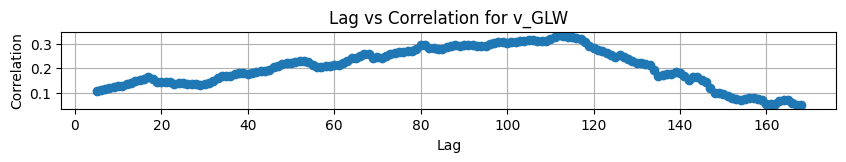

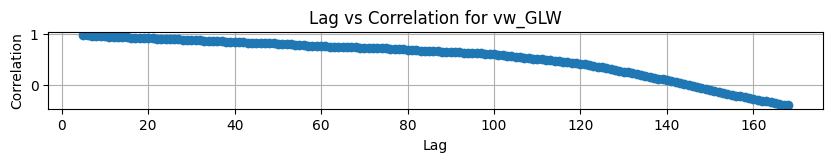

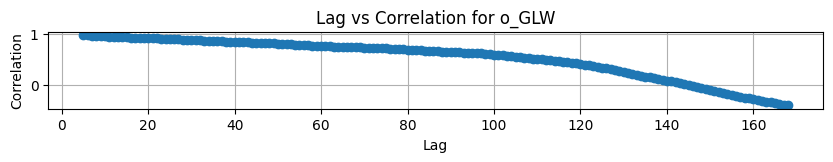

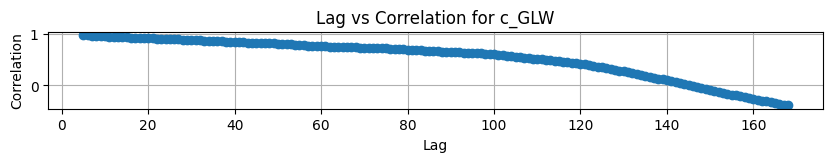

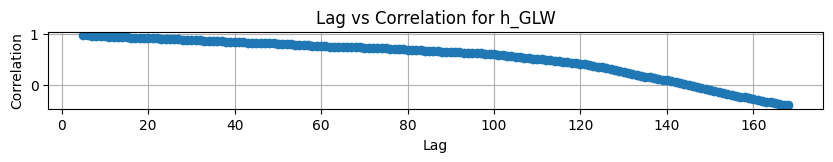

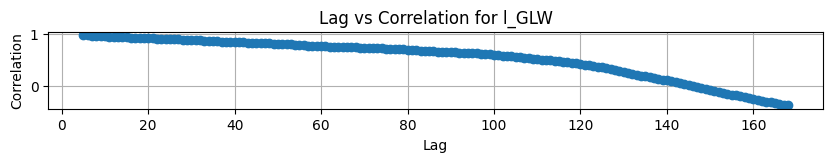

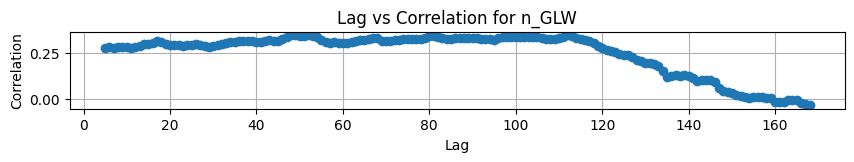

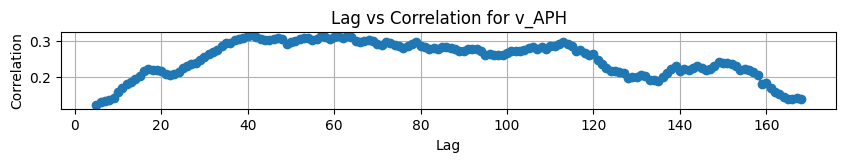

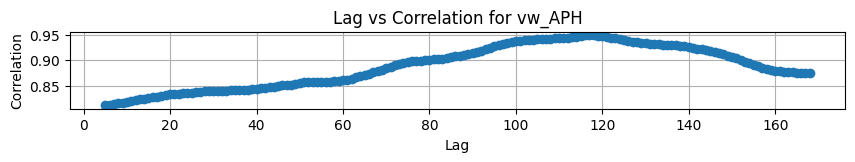

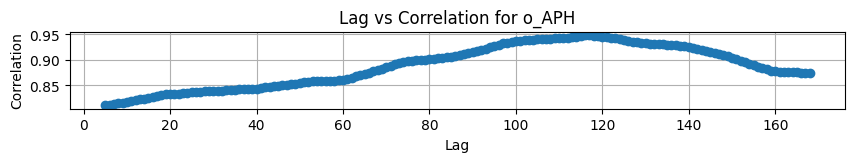

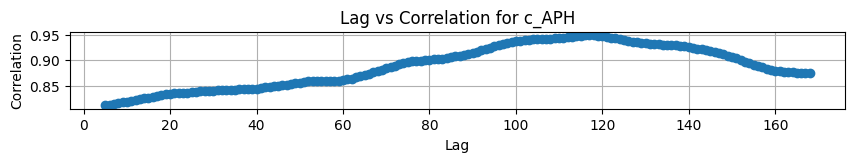

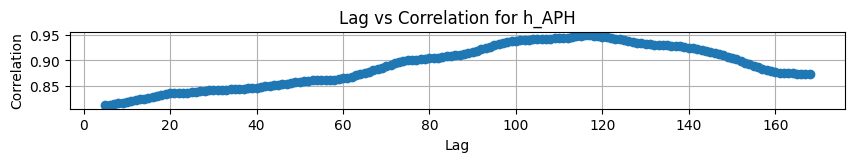

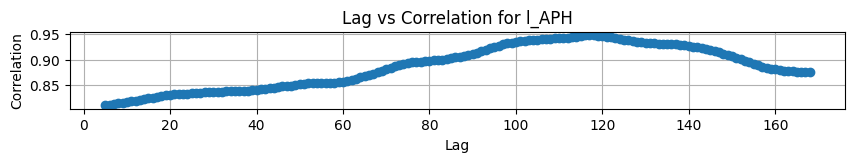

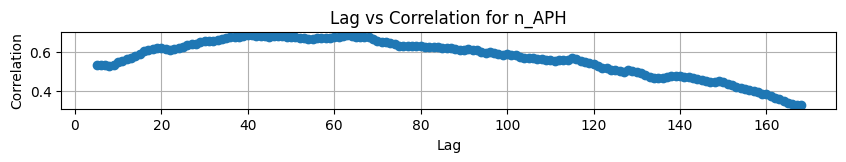

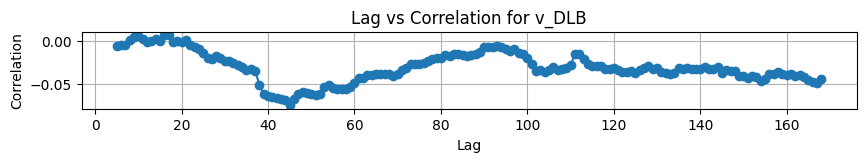

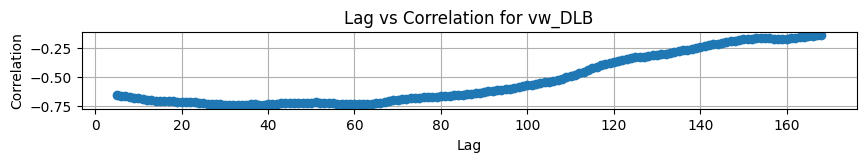

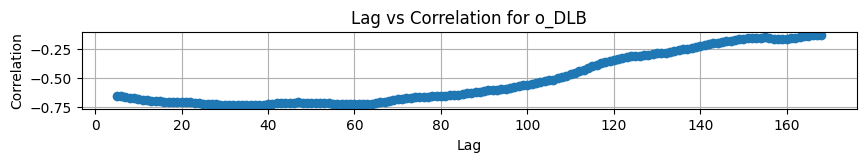

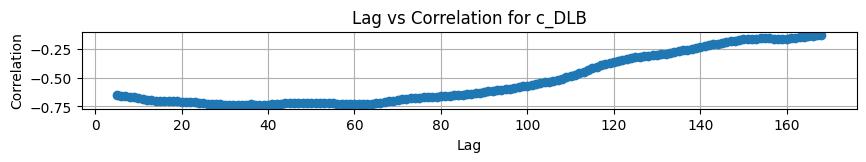

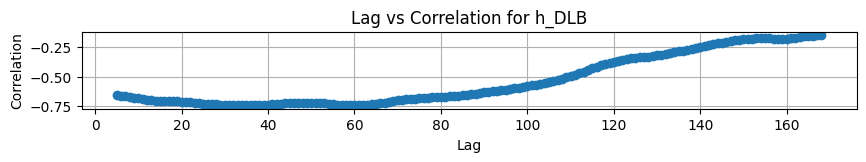

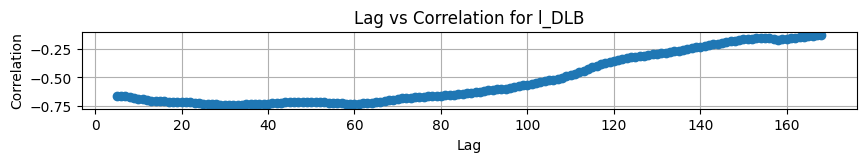

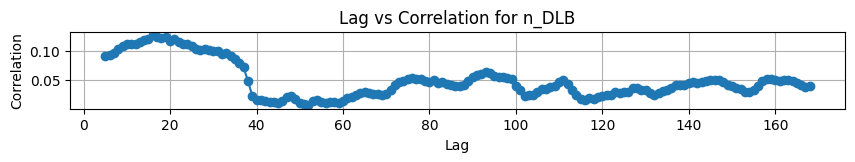

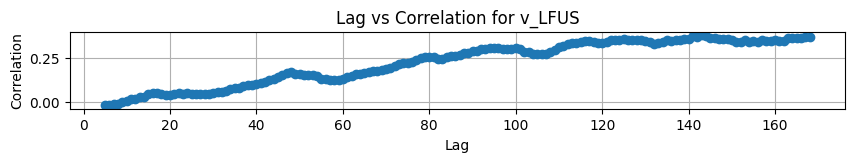

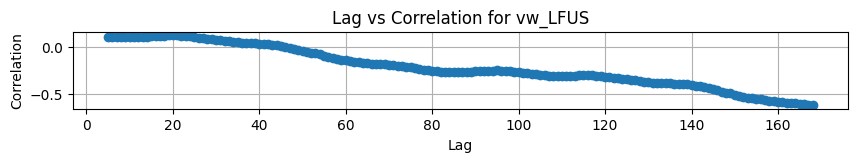

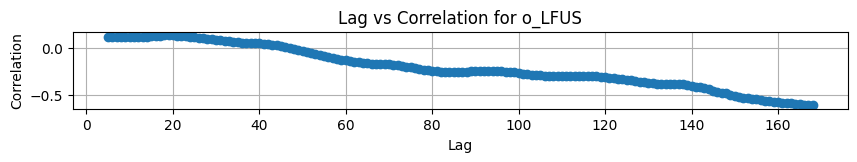

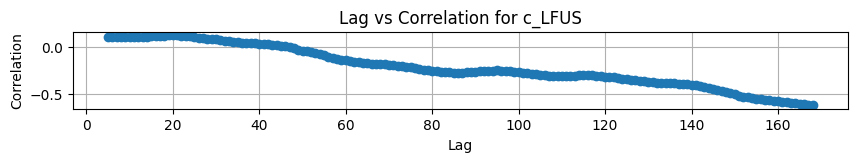

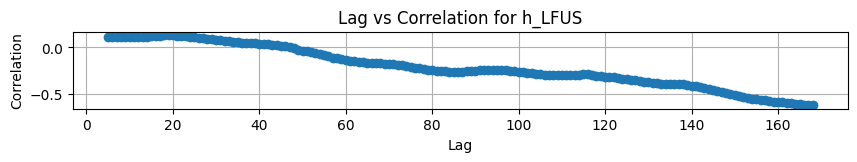

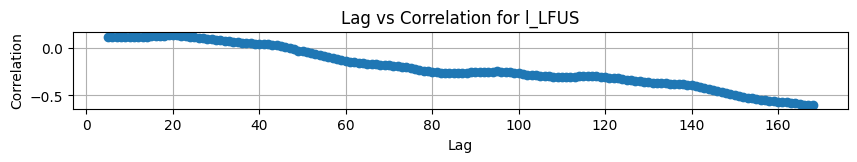

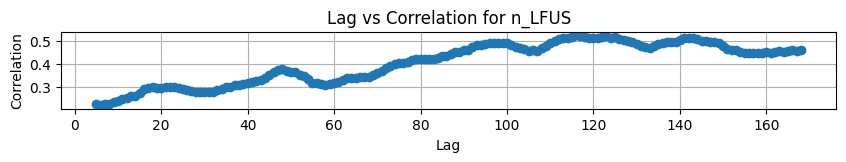

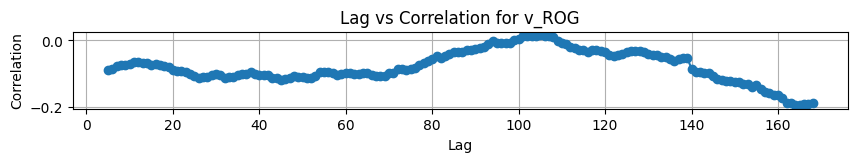

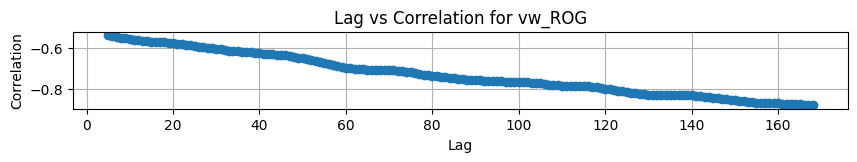

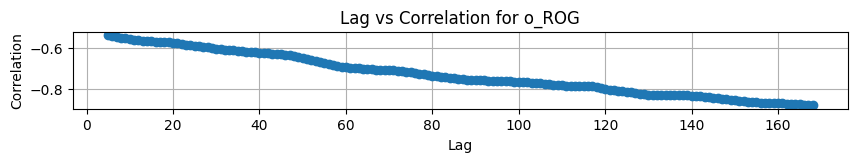

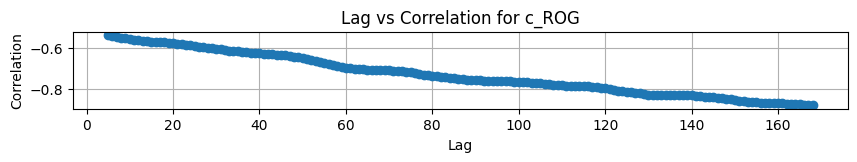

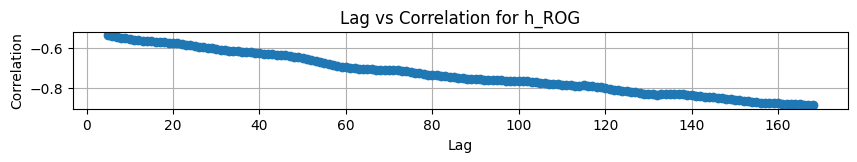

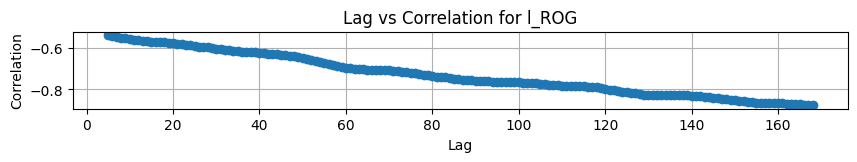

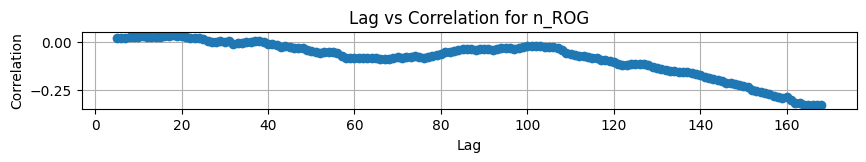

In [29]:
# Only a few double peaks so maxiumum can be used
plot_correlations(stock_prices_df,max_lag = 28 * 6)

In [30]:
top_corr_columns

,column,lag,correlation
1,v_GLW,6,0.111836
1,vw_GLW,6,0.976363
1,o_GLW,6,0.974075
1,c_GLW,6,0.976661
1,h_GLW,6,0.975439
...,...,...,...
1,o_ROG,6,-0.543827
1,c_ROG,6,-0.541767
1,h_ROG,6,-0.541432
1,l_ROG,6,-0.544198


In [15]:
lagged_df = pd.DataFrame()

for index, row in top_corr_columns.iterrows():
    column_name = row['column']
    lag_amount = row['lag']
    
    # Shift the column by the specified lag amount
    lagged_column = stock_prices_df[column_name].shift(lag_amount)
    
    # Add the lagged column to the new dataframe
    lagged_df[column_name] = lagged_column

# Drop rows with NaN values resulting from the lagging process
lagged_df.dropna(inplace=True)

In [16]:
# 99% of autocorrelation variation done by 2 previous columns 
pca = PCA(n_components=0.99)
pca_result = pca.fit_transform(lagged_df)

# Convert PCA result to a dataframe
pca_df = pd.DataFrame(pca_result)
pca_df

,0,1,2
0,5.823818e+06,7.878364e+06,178610.875770
1,1.198829e+06,2.318050e+06,93773.791842
2,3.524934e+05,3.438728e+05,191132.392843
3,-2.251367e+05,-8.877676e+05,344098.789483
4,-4.815158e+05,6.898472e+05,254276.639299
...,...,...,...
321,-1.552612e+06,-6.115130e+05,-142993.287737
322,-2.023961e+06,-8.039080e+05,-147782.262680
323,1.167552e+06,2.061429e+06,98890.326495
324,5.191880e+05,-2.084713e+06,-107050.848332


In [17]:
# Create function for processing data later 

def comp_corr_pca(df, target_col, min_lag=5, max_lag=50):

    # Generate top correlations
    top_corr_columns = generate_top_correlations(df, target_col, min_lag, max_lag)
    
    # Create a new DataFrame for lagged columns
    lagged_df = pd.DataFrame()
    for index, row in top_corr_columns.iterrows():
        column_name = row['column']
        lag_amount = row['lag']
        lagged_df[column_name] = df[column_name].shift(lag_amount)
    lagged_df.dropna(inplace=True)

    # Ensure only numeric columns are used for PCA
    numeric_lagged_df = lagged_df.select_dtypes(include=['number'])

    # Perform PCA to reduce dimensionality
    pca = PCA(n_components=0.99)
    pca_result = pca.fit_transform(numeric_lagged_df)
    pca_df = pd.DataFrame(pca_result, index=lagged_df.index)

    # Add the PCA columns to the original df
    for i in range(pca_df.shape[1]):
        df[f"Competitor_PCA_{i+1}"] = pca_df.iloc[:, i]

    return df

## Excluded Standerd deviation
Later on it may be beneficial to exclude large fluctuation in stock 

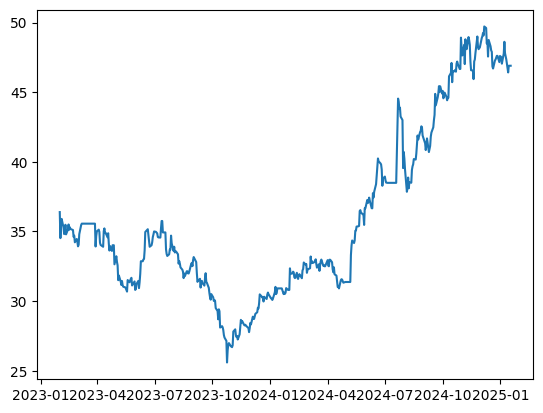

In [18]:
stock_prices_df_plot = stock_prices_df.copy()

# Predicting 5 days into the future so use rolling 5 days standerd deviation 
stock_prices_df_plot[pred_stock + '_std'] =  stock_prices_df_plot[pred_stock].rolling(window=20).std()

# Initialize the last valid value
last_valid_value = stock_prices_df_plot.loc[0, 'o_GLW']

# Create a new column 'o_GLW_no_dev' and copy the original 'o_GLW' values
stock_prices_df_plot['o_GLW_no_dev'] = stock_prices_df_plot['o_GLW']

# Forward fill the previous stock price when the magnitude of the deviation is greater than a threshold
for i in range(1, len(stock_prices_df_plot)):
    threshold = 2 * stock_prices_df_plot.loc[i, 'o_GLW_std']  # Update threshold based on the most recent std
    if abs(stock_prices_df_plot.loc[i, 'o_GLW'] - last_valid_value) > threshold:
        stock_prices_df_plot.loc[i, 'o_GLW_no_dev'] = last_valid_value
    else:
        last_valid_value = stock_prices_df_plot.loc[i, 'o_GLW']

plt.plot(stock_prices_df_plot['t'] ,stock_prices_df_plot['o_GLW_no_dev'])

In [19]:
# Changed to function so can possibly be implemented in the end to improve accuracy 
def remove_deviation(df, target_column):
    

    # Calculate rolling standard deviation
    df[target_column + '_std'] = df[target_column].rolling(window=20).std()

    # Initialize the last valid value
    last_valid_value = df.loc[0, target_column]

    # Create a new column for the adjusted values
    adjusted_column = target_column + '_no_dev'
    df[adjusted_column] = df[target_column]

    # Forward fill the previous stock price when the magnitude of the deviation is greater than a threshold
    for i in range(1, len(df)):
        threshold = 2 * df.loc[i-1, target_column + '_std']  # Update threshold based on the most recent std
        if abs(df.loc[i, target_column] - last_valid_value) > threshold:
            df.loc[i, adjusted_column] = last_valid_value
        else:
            last_valid_value = df.loc[i, target_column]

    return df

## Does std affect later volumes of trading 

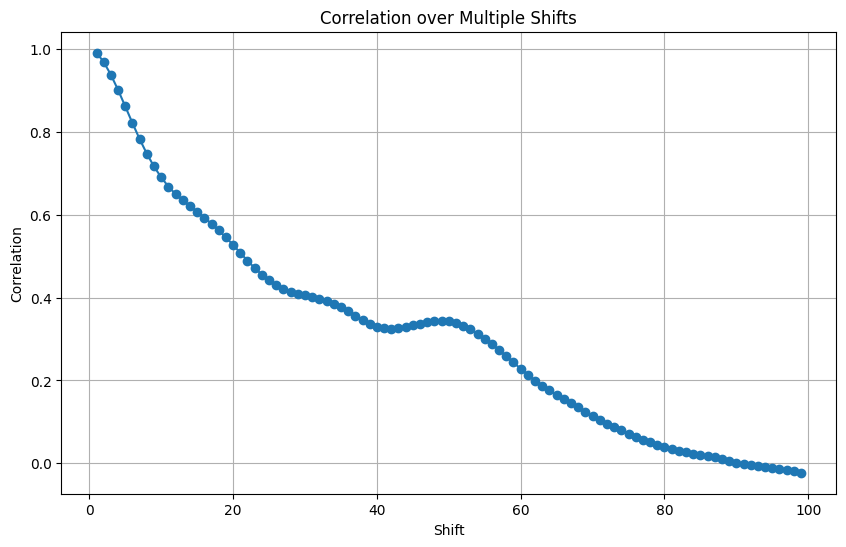

In [20]:
shifts = range(1, 100)
correlations = []

for shift in shifts:
    shifted_column_o_GLW = stock_prices_df_plot['o_GLW'].shift(-shift)
    shifted_column_o_GLW_std = stock_prices_df_plot['o_GLW_std'].shift(-shift)
    
    combined_df = pd.DataFrame({
        'product': stock_prices_df_plot['o_GLW'] * stock_prices_df_plot['o_GLW_std'],
        'shifted_product': shifted_column_o_GLW * shifted_column_o_GLW_std
    }).dropna()
    
    correlation = np.corrcoef(combined_df['product'], combined_df['shifted_product'])[0, 1]
    correlations.append(correlation)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(shifts, correlations, marker='o')
plt.title('Correlation over Multiple Shifts')
plt.xlabel('Shift')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

Peaks at 47 days shows this may be a usefull metric to add

## Pct changes 

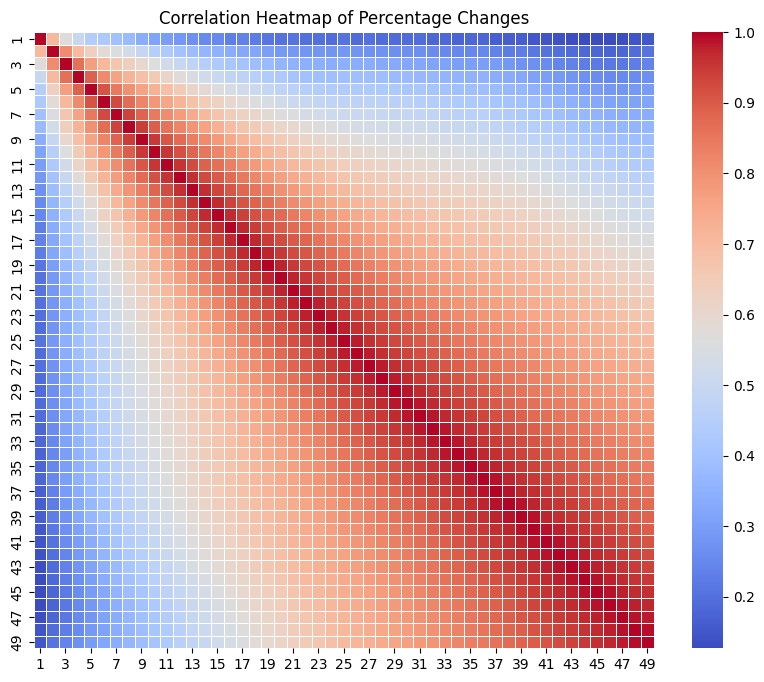

In [21]:
# Create the correlation matrix of percentage changes
pct_change_corr_df = pd.DataFrame([])

for i in range(1, 50):
    pct_change_df = pd.DataFrame(stock_prices_df[pred_stock].pct_change(-i))
    pct_change_df.columns = [str(i)]
    pct_change_corr_df = pd.concat([pct_change_corr_df, pct_change_df], axis=1)

corr_matrix = pct_change_corr_df.corr()

# Generate a heatmap with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap of Percentage Changes')
plt.show()

In [22]:
# Introduce on the most recent pct changes to the data
# We start to see very low correlations after 20 days to this will be the max 

def pct_change(df,target_col):
    '''
    Input 
    df - Stock dataframe
    target_col - target column you wish to get pct changes from

    Ouput
    df - original data frame with pct changes for 1,5,10 and 20 days 

    '''

    df[target_col + '_1_day_pct_chng'] = df[target_col].pct_change(-1)
    df[target_col + '_5_day_pct_chng'] = df[target_col].pct_change(-5)
    df[target_col + '_10_day_pct_chng'] = df[target_col].pct_change(-10)
    df[target_col + '_20_day_pct_chng'] = df[target_col].pct_change(-20)

    return df

## Loss aversion 
- Works on the percent change to identify the fact that dips in stock price are seen as worse than gains 

In [23]:
def loss_aversion_change(df, target_col):
    '''
    Input 
    df - Stock dataframe
    target_col - target column you wish to get pct changes from

    Ouput
    df - original data frame with the loss aversion function equation applied 

    '''

    def loss_aversion_function(x, alpha=0.88, beta=0.88, lambda_=2.5):
        if x >= 0:
            return x ** alpha
        else:
            return -lambda_ * (-x) ** beta
    
    df['loss_averse_' + target_col] = df[target_col].apply(lambda x: loss_aversion_function(x))

    return df

## Moving averages and time series analysis

In [24]:
def calculate_mse(df, window, prediction_days, method='MA'):
    df = df.copy() 
    
    if method == 'MA':
        df['average'] = df[pred_stock].rolling(window=window).mean()
    elif method == 'EMA':
        df['average'] = df[pred_stock].ewm(span=window, adjust=False).mean()
    else:
        raise ValueError("Method must be 'MA' or 'EMA'")
    
    mse_list = []
    
    for i in range(len(df) - window - prediction_days + 1):
        actual = df[pred_stock][i + window:i + window + prediction_days].values
        predicted = df['average'][i + window:i + window + prediction_days].values
        mse = mean_squared_error(actual, predicted)
        mse_list.append(mse)
    
    return np.mean(mse_list)

def evaluate_mse(stock_prices_df, max_window=28, prediction_days=5, method='MA'):
    results = []

    for window in range(1, max_window + 1):
        mse_list = []
        for start_day in range(len(stock_prices_df) - window - 30, len(stock_prices_df) - window - 5):
            mse = calculate_mse(stock_prices_df.iloc[start_day:], window, prediction_days, method)
            mse_list.append(mse)
        avg_mse = np.mean(mse_list)
        results.append({'window': window, 'mse': avg_mse})

    results_df = pd.DataFrame(results)

    plt.plot(results_df['window'], results_df['mse'])
    plt.xlabel('Window Size')
    plt.ylabel('Mean Squared Error')
    plt.title(f'MSE vs Window Size ({method})')
    plt.show()

    return results_df


### Moving Average 

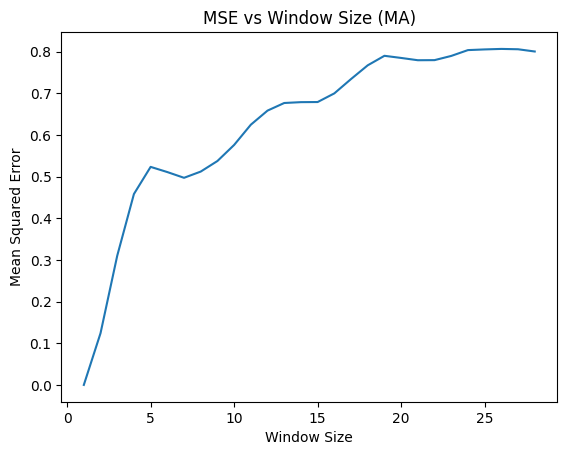

In [25]:
mse_ma = evaluate_mse(stock_prices_df, method='MA')

### Exponential moving average 

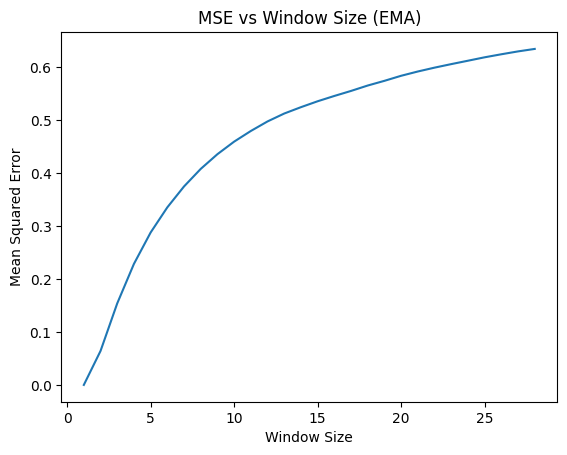

In [26]:
mse_ema = evaluate_mse(stock_prices_df, method='EMA')

### Prophet

11:33:34 - cmdstanpy - INFO - Chain [1] start processing
11:33:34 - cmdstanpy - INFO - Chain [1] done processing
11:33:34 - cmdstanpy - INFO - Chain [1] start processing
11:33:34 - cmdstanpy - INFO - Chain [1] done processing
11:33:35 - cmdstanpy - INFO - Chain [1] start processing
11:33:35 - cmdstanpy - INFO - Chain [1] done processing
11:33:35 - cmdstanpy - INFO - Chain [1] start processing
11:33:35 - cmdstanpy - INFO - Chain [1] done processing
11:33:35 - cmdstanpy - INFO - Chain [1] start processing
11:33:35 - cmdstanpy - INFO - Chain [1] done processing
11:33:35 - cmdstanpy - INFO - Chain [1] start processing
11:33:35 - cmdstanpy - INFO - Chain [1] done processing
11:33:35 - cmdstanpy - INFO - Chain [1] start processing
11:33:36 - cmdstanpy - INFO - Chain [1] done processing
11:33:36 - cmdstanpy - INFO - Chain [1] start processing
11:33:36 - cmdstanpy - INFO - Chain [1] done processing
11:33:36 - cmdstanpy - INFO - Chain [1] start processing
11:33:36 - cmdstanpy - INFO - Chain [1]

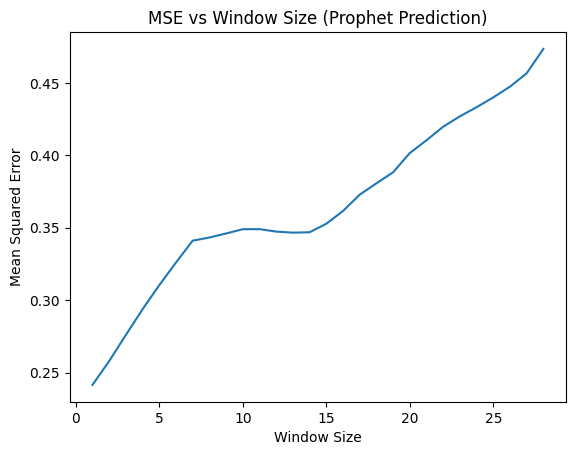

In [27]:
# Suppress cmdstanpy INFO messages
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

# Suppress Prophet INFO messages
logging.getLogger('prophet').setLevel(logging.ERROR)

# Suppress other related INFO messages
logging.getLogger('fbprophet').setLevel(logging.ERROR)

# Function to calculate mean squared error using Prophet
def calculate_mse_prophet(df, prediction_days):
    df = df.copy()  # Avoid modifying the original DataFrame
    df['y'] = df[pred_stock]
    df['ds'] = df['t']
    
    # Fit the model
    model = Prophet()
    model.fit(df[['ds', 'y']])
    
    # Make future dataframe
    future = model.make_future_dataframe(periods=prediction_days)
    
    # Predict
    forecast = model.predict(future)
    
    mse_list = []
    
    for i in range(len(df) - prediction_days + 1):
        actual = df[pred_stock][i:i + prediction_days].values
        predicted = forecast['yhat'][i:i + prediction_days].values
        mse = mean_squared_error(actual, predicted)
        mse_list.append(mse)
    
    return np.mean(mse_list)

# Iterate over all windows up to 28 days and predict 5 days in the future, excluding the last 5 days
results = []

for window in range(1, 29):
    mse_list = []
    for start_day in range(len(stock_prices_df) - window - 30, len(stock_prices_df) - window - 10):  # Exclude the last 5 days
        mse = calculate_mse_prophet(stock_prices_df.iloc[start_day:], 5)
        mse_list.append(mse)
    avg_mse = np.mean(mse_list)
    results.append({'window': window, 'mse': avg_mse})

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Plot the results
plt.plot(results_df['window'], results_df['mse'])
plt.xlabel('Window Size')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Window Size (Prophet Prediction)')
plt.show()

- Although Prophet stabilises quicker in its and has lower error overall, we will use EMA ad 5 days lag due to it having the lowest error overall 
- Greater than 5 days will be used due to predicting 5 days into the future

## Variations of model and adjustments to the data

### Add columns to original data frame

In [28]:
stock_prices_model_df = stock_prices_df.copy()

#add stock price with removed deviations
stock_prices_model_df = remove_deviation(stock_prices_model_df,pred_stock)

#Lagged values with competitor stocks and PCA to decrease overfitting 
stock_prices_model_df = comp_corr_pca(stock_prices_model_df,pred_stock)

#Pct_changes
stock_prices_model_df = pct_change(stock_prices_model_df,pred_stock)

#Run loss aversion on the pct changes
for i in ['o_GLW_1_day_pct_chng','o_GLW_5_day_pct_chng','o_GLW_10_day_pct_chng','o_GLW_20_day_pct_chng']:
    stock_prices_model_df = loss_aversion_change(stock_prices_model_df,i)

# Add optimal 5 day rolling average 
stock_prices_model_df[pred_stock + '_EMA'] = stock_prices_model_df[pred_stock].ewm(span=5, adjust=False).mean()

# Add in 47 day lag of std * price as there is a promising correlation between the two 
stock_prices_model_df['o_GLW_std_price'] = stock_prices_model_df['o_GLW_std'].shift(-47) * stock_prices_model_df['o_GLW'].shift(-47)

stock_prices_model_df = stock_prices_model_df.drop(list(stock_prices_df.drop([pred_stock],axis = 1).columns),axis = 1).dropna()

stock_prices_model_df.head()
    

,o_GLW,o_GLW_std,o_GLW_no_dev,Competitor_PCA_1,Competitor_PCA_2,Competitor_PCA_3,o_GLW_1_day_pct_chng,o_GLW_5_day_pct_chng,o_GLW_10_day_pct_chng,o_GLW_20_day_pct_chng,loss_averse_o_GLW_1_day_pct_chng,loss_averse_o_GLW_5_day_pct_chng,loss_averse_o_GLW_10_day_pct_chng,loss_averse_o_GLW_20_day_pct_chng,o_GLW_EMA,o_GLW_std_price
69,31.44,1.262555,31.44,1.437584e+05,8.293029e+05,52861.454530,0.009634,0.020779,-0.005063,-0.015962,0.016817,0.033076,-0.023869,-0.065564,31.593862,21.554459
70,31.14,1.261073,31.14,-9.930628e+05,1.029896e+06,-161618.068980,0.003545,0.014993,-0.016735,-0.052343,0.006977,0.024820,-0.068349,-0.186439,31.442575,23.071829
71,31.03,1.235826,31.03,-1.934354e+06,-1.840691e+06,-236159.085295,0.001291,-0.015233,-0.002892,-0.055691,0.002868,-0.062921,-0.014581,-0.196893,31.305050,24.824523
72,30.99,1.210921,30.99,-6.243572e+05,-2.182521e+06,-154078.492980,0.002264,-0.011483,-0.013372,-0.060624,0.004702,-0.049068,-0.056102,-0.212163,31.200033,25.922080
73,30.92,1.129235,30.92,3.431206e+05,-1.938019e+06,-17184.908067,0.003896,-0.017789,0.003896,-0.063598,0.007581,-0.072123,0.007581,-0.221294,31.106689,26.582196


In [29]:
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

def calculate_metrics(model, train, test, pred_stock):
    model.fit(train.drop(columns=[pred_stock]), train[pred_stock])
    predictions = model.predict(test.drop(columns=[pred_stock]))
    mse = mean_squared_error(test[pred_stock], predictions)
    mae = mean_absolute_error(test[pred_stock], predictions)
    r2 = r2_score(test[pred_stock], predictions)
    return mse, mae, r2

def print_loading_bar(iteration, total, length=50):
    percent = ("{0:.1f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = '█' * filled_length + '-' * (length - filled_length)
    sys.stdout.write(f'\r|{bar}| {percent}% Complete')
    sys.stdout.flush()

def evaluate_model_for_windows(model_info, stock_prices_model_df, pred_stock, total_windows=28):
    results = []
    scaler = StandardScaler()
    model = model_info['model']
    grid_search = GridSearchCV(estimator=model, param_grid=model_info['params'], cv=3)
    
    for window in range(1, total_windows + 1):
        start_idx = -30 - (window * 5)
        end_idx = start_idx + 5
        train = stock_prices_model_df.iloc[:start_idx]
        test = stock_prices_model_df.iloc[start_idx:end_idx]
        
        # Normalize the data
        train_scaled = scaler.fit_transform(train.drop(columns=[pred_stock]))
        test_scaled = scaler.transform(test.drop(columns=[pred_stock]))
        
        train_scaled = pd.DataFrame(train_scaled, columns=train.drop(columns=[pred_stock]).columns)
        test_scaled = pd.DataFrame(test_scaled, columns=test.drop(columns=[pred_stock]).columns)
        
        train_scaled[pred_stock] = train[pred_stock].values
        test_scaled[pred_stock] = test[pred_stock].values
        
        grid_search.fit(train_scaled.drop(columns=[pred_stock]), train_scaled[pred_stock])
        
        best_model = grid_search.best_estimator_
        
        mse, mae, r2 = calculate_metrics(best_model, train_scaled, test_scaled, pred_stock)
        results.append({'window': window, 'mse': mse, 'mae': mae, 'r2': r2})
        
        print_loading_bar(window, total_windows)
    
    print()  # Move to the next line after completion
    return results

In [30]:

models = {
    'neural_network': {
        'model': MLPRegressor(max_iter=200),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'activation': ['relu', 'tanh', 'logistic'],
            'solver': ['adam', 'sgd']
        }
    },
    'linear_regression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False]
        }
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30]
        }
    },
    'xgboost': {
        'model': XGBRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    }
}

total_windows = 28
results = {model_name: evaluate_model_for_windows(model_info, stock_prices_model_df, pred_stock, total_windows) for model_name, model_info in models.items()}

# Calculate average metrics for each model
average_metrics = {}
for model_name, metrics in results.items():
    avg_mse = np.mean([m['mse'] for m in metrics])
    avg_mae = np.mean([m['mae'] for m in metrics])
    avg_r2 = np.mean([m['r2'] for m in metrics])
    average_metrics[model_name] = {'avg_mse': avg_mse, 'avg_mae': avg_mae, 'avg_r2': avg_r2}

print("Average Metrics for Each Model:")
for model_name, metrics in average_metrics.items():
    print(f"{model_name}: MSE={metrics['avg_mse']}, MAE={metrics['avg_mae']}, R2={metrics['avg_r2']}")

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|█-------------------------------------------------| 3.6% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|███-----------------------------------------------| 7.1% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|█████---------------------------------------------| 10.7% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|███████-------------------------------------------| 14.3% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|████████------------------------------------------| 17.9% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|██████████----------------------------------------| 21.4% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|████████████--------------------------------------| 25.0% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|██████████████------------------------------------| 28.6% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|████████████████----------------------------------| 32.1% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|█████████████████---------------------------------| 35.7% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|███████████████████-------------------------------| 39.3% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|█████████████████████-----------------------------| 42.9% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|███████████████████████---------------------------| 46.4% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|█████████████████████████-------------------------| 50.0% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|██████████████████████████------------------------| 53.6% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|████████████████████████████----------------------| 57.1% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|██████████████████████████████--------------------| 60.7% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|████████████████████████████████------------------| 64.3% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|█████████████████████████████████-----------------| 67.9% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|███████████████████████████████████---------------| 71.4% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|█████████████████████████████████████-------------| 75.0% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|███████████████████████████████████████-----------| 78.6% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|█████████████████████████████████████████---------| 82.1% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|██████████████████████████████████████████--------| 85.7% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|████████████████████████████████████████████------| 89.3% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|██████████████████████████████████████████████----| 92.9% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|████████████████████████████████████████████████--| 96.4% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum i

|██████████████████████████████████████████████████| 100.0% Complete

c:\Users\benedict.grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
Average Metrics for Each Model:
neural_network: MSE=7.397058604523962, MAE=1.6195211479038172, R2=-82.62214389651716
linear_regression: MSE=0.8420147574058962, MAE=0.5165884742132308, R2=-2.344169055539644
random_forest: MSE=1.627894913529127, MAE=0.74583940816326, R2=-17.586548264349
xgboost: MSE=1.267897195105413, MAE=0.6580647152491979, R2=-2.4658706000806743


Linear regression has by far the best ouptut most likley due to the smalle sample size we have available with other methods overfitting

In [31]:
# Function to calculate VIF
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Assuming 'stock_prices_model_df' is your DataFrame
# Drop the target variable 'pred_stock' from the features
features_df = stock_prices_model_df.drop(columns=[pred_stock])

# Calculate VIF for each feature
vif_df = calculate_vif(features_df)

vif_df

,feature,VIF
0,o_GLW_std,6.459031
1,o_GLW_no_dev,2215.181977
2,Competitor_PCA_1,1.026091
3,Competitor_PCA_2,1.048876
4,Competitor_PCA_3,1.024359
5,o_GLW_1_day_pct_chng,16.216646
6,o_GLW_5_day_pct_chng,33.318110
7,o_GLW_10_day_pct_chng,34.476041
8,o_GLW_20_day_pct_chng,29.704081
9,loss_averse_o_GLW_1_day_pct_chng,17.434782


In [32]:
for i in stock_prices_model_df.drop(pred_stock,axis = 1).columns:
    results_linear_regression = evaluate_model_for_windows(linear_regression_model_info[[i,pred_stock]], stock_prices_model_df, pred_stock, total_windows)

    average_metrics_linear_regression = {}
    avg_mse = np.mean([m['mse'] for m in results_linear_regression])
    avg_mae = np.mean([m['mae'] for m in results_linear_regression])
    avg_r2 = np.mean([m['r2'] for m in results_linear_regression])
    average_metrics_linear_regression['linear_regression'] = {'avg_mse': avg_mse, 'avg_mae': avg_mae, 'avg_r2': avg_r2}

NameError: name 'linear_regression_model_info' is not defined

In [41]:
# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['column', 'avg_mse', 'avg_mae', 'avg_r2'])

# Loop through each column in the DataFrame except the prediction stock column
for i in stock_prices_model_df.drop(pred_stock, axis=1).columns:
    # Evaluate the model for the current column
    results_linear_regression = evaluate_model_for_windows(linear_regression_model_info, stock_prices_model_df[[i, pred_stock]], pred_stock, total_windows)

    # Calculate average metrics
    avg_mse = np.mean([m['mse'] for m in results_linear_regression])
    avg_mae = np.mean([m['mae'] for m in results_linear_regression])
    avg_r2 = np.mean([m['r2'] for m in results_linear_regression])

    # Store the results in the DataFrame
    new_row = pd.DataFrame({'column': [i], 'avg_mse': [avg_mse], 'avg_mae': [avg_mae], 'avg_r2': [avg_r2]})
    results_df = pd.concat([results_df, new_row], ignore_index=True)

|██████████████████████████████████████████████████| 100.0% Complete
|████████████████----------------------------------| 32.1% Complete

C:\Users\benedict.grant\AppData\Local\Temp\ipykernel_3244\1706112881.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete
|██████████████████████████████████████████████████| 100.0% Complete


In [42]:
results_df

,column,avg_mse,avg_mae,avg_r2
0,o_GLW_std,25.712039,4.092733,-200.536066
1,o_GLW_no_dev,3.285419,0.858645,-79.547399
2,Competitor_PCA_1,38.972725,5.115019,-387.950722
3,Competitor_PCA_2,47.902528,5.665628,-469.422369
4,Competitor_PCA_3,46.970227,5.694236,-457.999580
5,o_GLW_1_day_pct_chng,47.872946,5.758276,-458.471688
6,o_GLW_5_day_pct_chng,48.839826,5.834482,-481.744125
7,o_GLW_10_day_pct_chng,49.543956,5.906657,-517.092073
8,o_GLW_20_day_pct_chng,49.980642,6.052808,-487.113577
9,loss_averse_o_GLW_1_day_pct_chng,47.778181,5.751673,-459.287457


In [43]:
# Linear Regression model with intercept=True
linear_regression_model_info = {
    'model': LinearRegression(),
    'params': {
        'fit_intercept': [True]
    }
}

results_linear_regression = evaluate_model_for_windows(linear_regression_model_info, stock_prices_model_df.drop('o_GLW_no_dev',axis = 1), pred_stock, total_windows)

# Calculate average metrics for the linear regression model
average_metrics_linear_regression = {}
avg_mse = np.mean([m['mse'] for m in results_linear_regression])
avg_mae = np.mean([m['mae'] for m in results_linear_regression])
avg_r2 = np.mean([m['r2'] for m in results_linear_regression])
average_metrics_linear_regression['linear_regression'] = {'avg_mse': avg_mse, 'avg_mae': avg_mae, 'avg_r2': avg_r2}

print("Average Metrics for Linear Regression Model:")
for model_name, metrics in average_metrics_linear_regression.items():
    print(f"{model_name}: MSE={metrics['avg_mse']}, MAE={metrics['avg_mae']}, R2={metrics['avg_r2']}")

|██████████████████████████████████████████████████| 100.0% Complete
Average Metrics for Linear Regression Model:
linear_regression: MSE=0.5697078226082286, MAE=0.48540797227132054, R2=-1.2341539270030673


## Residual analysis

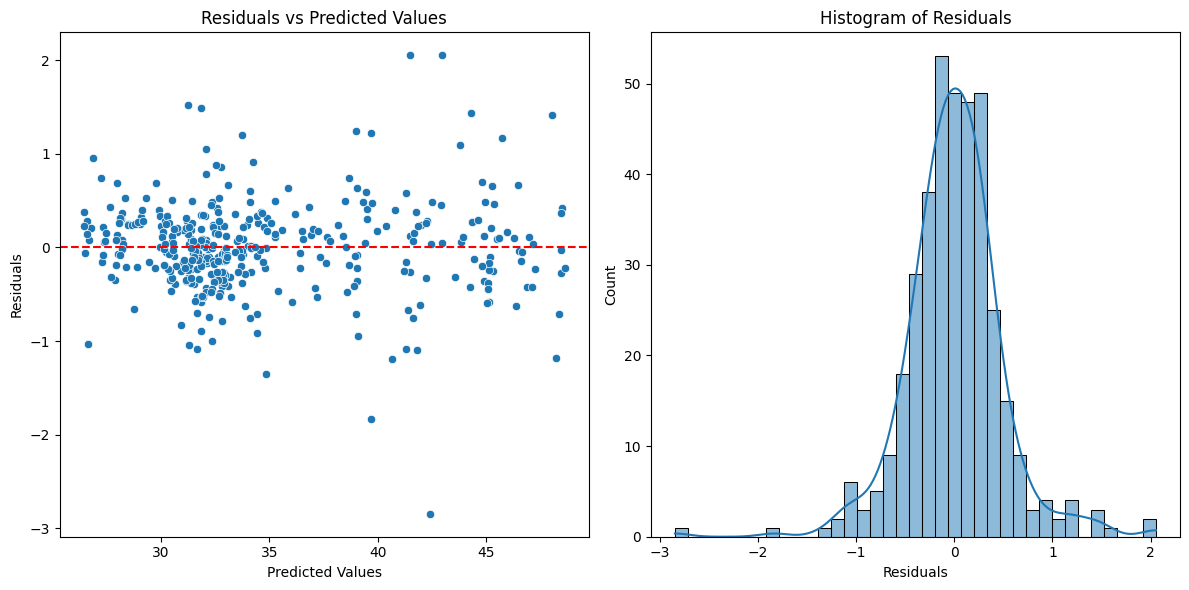

Mean Squared Error: 0.24089975826306373
R-squared: 0.9923973089089836


In [54]:
# Dropping the 'o_GLW_no_dev' column from the dataframe
stock_prices_model_df_cut = stock_prices_model_df.drop('o_GLW_no_dev', axis=1)

# Extracting features and target variable from the dataframe
X = stock_prices_model_df_cut.drop(pred_stock, axis=1)  # Replace 'target' with the actual target column name
y = stock_prices_model_df_cut[pred_stock]  # Replace 'target' with the actual target column name

# Defining the linear regression model with given parameters
linear_regression_model_info = {
    'model': LinearRegression(),
    'params': {
        'fit_intercept': [True]
    }
}

# Fitting the model to the data
model = linear_regression_model_info['model']
model.fit(X, y)

# Making predictions
y_pred = model.predict(X)

# Calculating residuals
residuals = y - y_pred

# Residual analysis
plt.figure(figsize=(12, 6))

# Plotting residuals
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')

# Plotting histogram of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')

plt.tight_layout()
plt.show()

# Printing performance metrics
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

## Final notes

## References 
- https://polygon.io/ - used to pull in stock prices 
- https://www.marketbeat.com/stocks/NYSE/GLW/competitors-and-alternatives/#:~:text=The%20main%20competitors%20of%20Corning,%2C%20and%20ARM%20(ARM). - Corning competitors